In [16]:
import tensorflow as tf

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#         for gpu in gpus:
#           tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         # Visible devices must be set before GPUs have been initialized
#         print(e)

import os
import math
import numpy as np
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import SeparableConv2D,UpSampling2D #
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.python.client import device_lib
from tensorflow.keras import backend as K
import time

from IPython.display import display

c:\users\tc950\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [17]:
#Get data set
#dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
#data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join("./", "dataset")
root_dir

'./dataset'

In [18]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8
AUTOTUNE = tf.data.AUTOTUNE

# train_ds = image_dataset_from_directory(
#     root_dir,
#     batch_size = batch_size,
#     image_size =(crop_size, crop_size),
#     validation_split=0.2,
#     subset="training",
#     seed=1337,
#     label_mode=None
# )


# https://www.tensorflow.org/tutorials/load_data/images
list_ds_lr = tf.data.Dataset.list_files(root_dir + '/Low/*', shuffle=False)
list_ds_lr = list_ds_lr.shuffle(list_ds_lr.cardinality().numpy(), reshuffle_each_iteration=False)
# list_ds_hr = tf.data.Dataset.list_files(root_dir + '/High/*', shuffle=False)
# list_ds_hr = list_ds_hr.shuffle(list_ds_hr.cardinality().numpy(), reshuffle_each_iteration=False)

val_size = int(list_ds_lr.cardinality().numpy() * 0.2) 

train_ds_lr = list_ds_lr.skip(val_size)
val_ds_lr = list_ds_lr.take(val_size)

# train_ds_hr = list_ds_hr.skip(val_size)
# val_ds_hr = list_ds_hr.take(val_size)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # resize the image to the desired size
  return tf.image.convert_image_dtype(img, dtype=tf.dtypes.float32, saturate=False, name=None)

def process_path(file_path, type):
  img = tf.io.read_file(file_path.numpy())
  img = decode_img(img)
  return img

def get_low_res_image(file_path):
  img = tf.io.read_file(file_path.numpy())
  img = decode_img(img)  
  return img

#Get high res image corresponding to the low res image
def get_high_res_image(file_path):
  path_str = file_path.numpy().decode("utf-8") 
  path = os.path.normpath(path_str)
  path_arr = path.split(os.sep)
  file_name_hr = path_arr[2]
  hr_file_path ='.'+ os.sep + path_arr[0] + os.sep + 'High' + os.sep + file_name_hr
  hr_image = tf.io.read_file(hr_file_path)
  hr_image = decode_img(hr_image)
  return hr_image

def get_luminance(img):
    input = tf.image.rgb_to_yuv(img)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y

def process_data_tuple(file_path):
  lr_image = get_low_res_image(file_path)
  lr_image = get_luminance(lr_image)
  lr_image = tf.image.resize(lr_image, [input_size, input_size], method="area")

  hr_image = get_high_res_image(file_path)  
  hr_image = get_luminance(hr_image)
  hr_image = tf.image.resize(hr_image, [crop_size, crop_size], method="area")
    
  return lr_image, hr_image

train_ds_lr = train_ds_lr.map(lambda x: tf.py_function(process_data_tuple, [x], [tf.float32,tf.float32]), num_parallel_calls=AUTOTUNE)
# train_ds_hr = train_ds_hr.map(lambda x: tf.py_function(process_path_train_hr, [x], [tf.float32,tf.string]), num_parallel_calls=AUTOTUNE)
val_ds_lr = val_ds_lr.map(lambda x: tf.py_function(process_data_tuple, [x], [tf.float32,tf.float32]), num_parallel_calls=AUTOTUNE)
# val_ds_hr = val_ds_hr.map(lambda x: tf.py_function(process_path_val_hr, [x], [tf.float32,tf.string]), num_parallel_calls=AUTOTUNE)

# for lr_img,hr_img in train_ds_lr.take(1):
#   print(lr_img)

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds_lr = configure_for_performance(train_ds_lr)
# train_ds_hr = configure_for_performance(train_ds_hr)
val_ds_lr = configure_for_performance(val_ds_lr)
# val_ds_hr = configure_for_performance(val_ds_hr)


# valid_ds = image_dataset_from_directory(
#     root_dir,
#     batch_size = batch_size,
#     image_size =(crop_size, crop_size),
#     validation_split=0.2,
#     subset="validation",
#     seed=1337,
#     label_mode=None
# )

In [19]:
def scaling(lr, hr):
    lr_scaled,hr_scaled = lr /255.0, hr/255.0
    # print(bytes.decode(label.numpy()))    
    return lr_scaled,hr_scaled


#scale from 0, 255 to 0,1
train_ds_lr= train_ds_lr.map(lambda x,y: tf.py_function(scaling, [x,y], [tf.float32,tf.float32]))
val_ds_lr= val_ds_lr.map(lambda x,y: tf.py_function(scaling, [x,y], [tf.float32,tf.float32]))


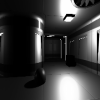

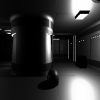

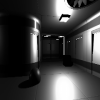

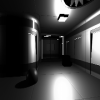

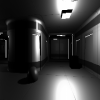

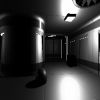

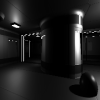

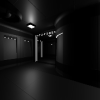

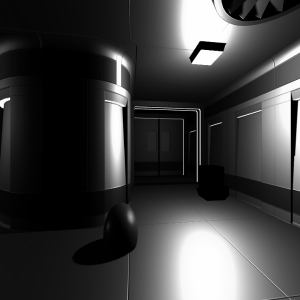

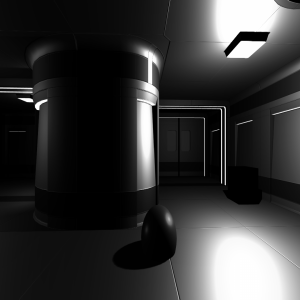

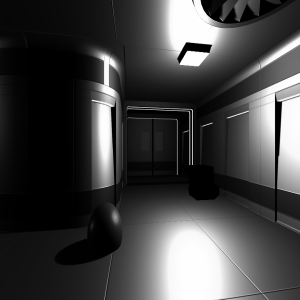

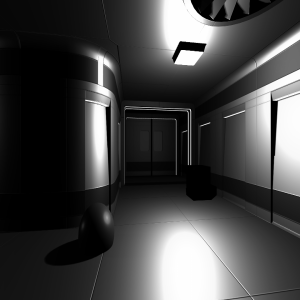

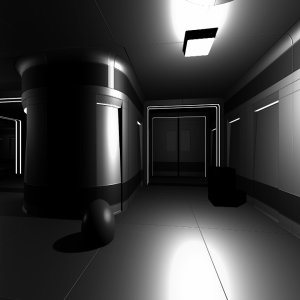

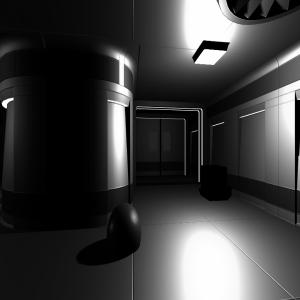

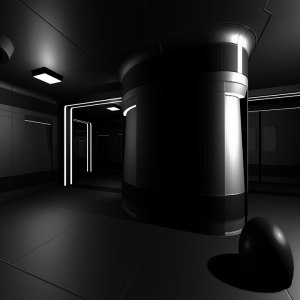

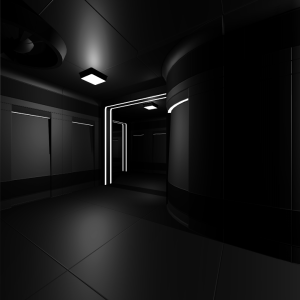

In [20]:
for batch in train_ds_lr.take(1):
    for img in batch[0]:
        display(array_to_img(img))          
    for img in batch[1]:
        display(array_to_img(img))

In [21]:
# dataset = os.path.join(root_dir, "images")
test_path = os.path.join(root_dir, "Low")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".png")
    ]
)

In [22]:
# def process_input(input, input_size, upscale_factor):
#     input = tf.image.rgb_to_yuv(input)
#     last_dimension_axis = len(input.shape) - 1
#     y, u, v = tf.split(input, 3, axis=last_dimension_axis)
#     return tf.image.resize(y, [input_size, input_size], method="area")


# def process_target(input):
#     input = tf.image.rgb_to_yuv(input)
#     last_dimension_axis = len(input.shape) - 1
#     y, u, v = tf.split(input, 3, axis=last_dimension_axis)
#     return y


# train_ds = train_ds.map(
#     lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
# )
# train_ds = train_ds.prefetch(buffer_size=32)

# valid_ds = valid_ds.map(
#     lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
# )
# valid_ds = valid_ds.prefetch(buffer_size=32)

In [23]:
# for batch in train_ds.take(1):
#     for img in batch[0]:
#         display(array_to_img(img))
#     for img in batch[1]:
#         display(array_to_img(img))

In [24]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_low_res_image_for_hr(img):
  return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )



In [26]:
def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    t0 = time.perf_counter()
    out = model.predict(input)
    t1 = time.perf_counter()
    print(t1-t0)
    
    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [27]:
# https://www.tensorflow.org/guide/keras/custom_callback
class RSS(keras.callbacks.Callback):
    def __init__(self):
        super(RSS, self).__init__()
        # train_ds_ls = tf.data.Dataset.from_tensor_slices(list(train_ds_hr))        
        self.test_img = get_low_res_image_for_hr(load_img(test_img_paths[0]))

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [28]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "./tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf.nn.depth_to_space_1 (TFOp (None, None, None, 1)     0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
_______________________________________________________

In [29]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# print(gpus)
# tf.config.set_visible_devices([], 'CPU') # hide the CPU
# tf.config.set_visible_devices(gpus[0], 'GPU') # unhide potentially hidden GPU
# tf.config.get_visible_devices()
train_ds_lr = train_ds_lr.prefetch(32)
val_ds_lr = val_ds_lr.prefetch(32)


epochs = 10

model.compile(
    optimizer=optimizer, loss=loss_fn,
)
with tf.device('/gpu:0'):
    model.fit(
        train_ds_lr, epochs=epochs, callbacks=callbacks, validation_data=val_ds_lr, verbose=2
    )

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

Epoch 1/10


UnknownError: 2 root error(s) found.
  (0) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model_1/conv2d_4/Conv2D (defined at <ipython-input-29-635b0320903c>:17) ]]
	 [[Func/mean_squared_error/cond/then/_0/input/_29/_58]]
  (1) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model_1/conv2d_4/Conv2D (defined at <ipython-input-29-635b0320903c>:17) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_10487]

Function call stack:
train_function -> train_function


In [ ]:
import time

total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[56:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
#     t0 = time.perf_counter()
    prediction = upscale_image(model, lowres_input)
#     t1 = time.perf_counter()
#     print(t1-t0)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)
    
    ssim1 = tf.image.ssim(predict_img_arr, highres_img_arr, max_val=255, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)
    
    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    print("SSIM of predict and high resolution is %.4f" % ssim1)
    
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save("model.h5")
model.save_weights('my_model_weights.h5')

In [ ]:
import time

total_bicubic_psnr = 0.0
total_test_psnr = 0.0

# for index, test_img_path in enumerate(test_img_paths[56:60]):
img = load_img('./My Images/0002 shotH.png')
lowres_input = img
w = lowres_input.size[0] * upscale_factor
h = lowres_input.size[1] * upscale_factor
highres_img = img.resize((w, h))
# t0 = time.perf_counter()
prediction = upscale_image(model, lowres_input)
# t1 = time.perf_counter()
# print(t1-t0)
lowres_img = lowres_input.resize((w, h))
lowres_img_arr = img_to_array(lowres_img)
highres_img_arr = img_to_array(highres_img)
predict_img_arr = img_to_array(prediction)
bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

ssim1 = tf.image.ssim(predict_img_arr, highres_img_arr, max_val=255, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)

total_bicubic_psnr += bicubic_psnr
total_test_psnr += test_psnr

print(
    "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
)
print("PSNR of predict and high resolution is %.4f" % test_psnr)
print("SSIM of predict and high resolution is %.4f" % ssim1)

plot_results(lowres_img, 1, "lowres")
plot_results(highres_img, 1, "highres")
plot_results(prediction, 1, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))

tf.keras.preprocessing.image.save_img(
    './Result/out', predict_img_arr, data_format=None, file_format='png', scale=True
)